***PARACHUTE LANDING : FINDING OPTIMAL PATHS:***

IMPORTS :

In [2]:
# Imports
import gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from collections import defaultdict
from collections import namedtuple
import itertools
import random
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import count
from torch.distributions import Categorical
import torch.optim as optim

In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
11.3
Tesla T4


global variables for graph construction:

In [3]:
EpisodeStats = namedtuple("Stats",["lengthReadings", "rewardReadings", "epsilon_values", "cummulative_rewards"])
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

Environment Definition:

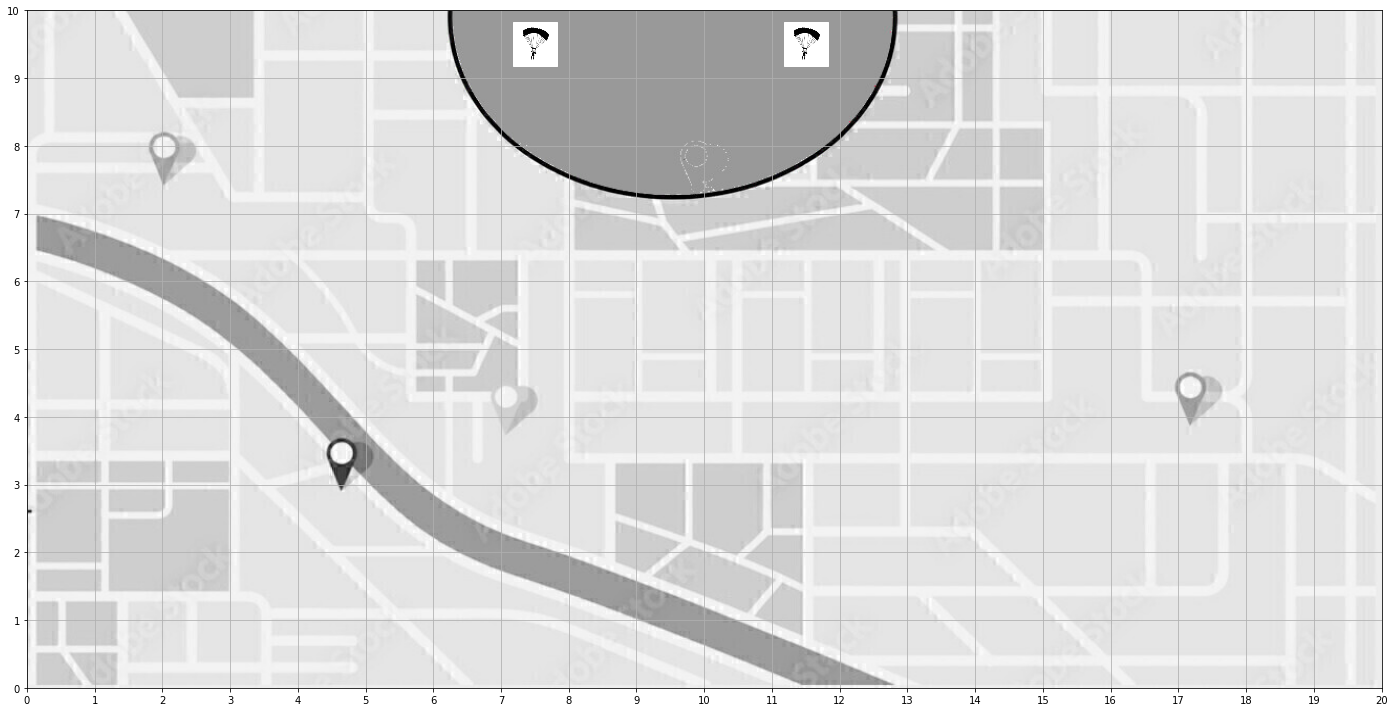

Parachute 1 reached goal!!! Details : 
Parachute 2 reached goal!!! Details : 
Total Reward in this episode = 140.0 Resetting environment!!!!!


In [13]:
class ParachuteLandingEnv(gym.Env):

    def __init__(self):

        self.total_width = 20
        self.total_height = 10

        self.total_area = self.total_width * self.total_height

        self.observation_space = spaces.Discrete(self.total_area)
        self.action_space = spaces.Discrete(9) # 0- Straight, 1- Left Diagonal(when left string is pulled) and 2- Right Diagonal(when right string is pulled)
        self.actionList = ['none_none', "none_leftpull", "none_rightpull", "leftpull_leftpull", "leftpull_none", "leftpull_rightpull", "rightpull_rightpull", "rightpull_none", "rightpull_leftpull"]


        #agent and destination points
        self.para_pos = np.asarray([[7, 0], [13,0]]) # Agent(Parachute) at height = total_height right above thiese grid points
        self.dest_pos = np.asarray([[7, 9], [8, 9], [9, 9], [10, 9], [11, 9], [12, 9], [13, 9], [12, 8], [8, 8], [9, 8], [10, 8], [11, 8], [11, 7], [9, 7], [10, 7]]) # Landing on Destination point : 100 points
        self.safe_pos = np.asarray([[0, 3], [3, 1], [4, 2], [5,7], [6,5], [7,6], [7,8]]) # landing on Safe points : 70 points
        # the remaining grids are unsafe points. Landing on unsafe points/crash landing : -100
        # Reward for each time step in the direction of destination = +10 and away from the destination = -10

        self.state_reward_mapping = {"para_pos":0,"dest_pos":100,"safe_pos":70}

        self.rewards = 0 #Total rewards collected per episode

        self.landingSpot = [-1, -1] # 0: destination stop, 1: safe spot, 2: crashed
        self.timesteps =  0 #No. of actions taken by the agent

        self.max_timesteps = self.total_height-1 #assume that by crossing each unit of the grid, the agent will cover a height of one unit.
    


    def reset(self): # Resetting the environment when a termination condition is satisfied

        #Printing appropriate status after termination
        if self.landingSpot[0] == 3 or self.landingSpot[1] == 3:
              print("Parachutes Crashed with each other!!! Details : ")
        else:
              for i in range(0,2):
                if self.landingSpot[i] == 0: 
                    print("Parachute "+str(i+1)+ " reached goal!!! Details : ")
                elif self.landingSpot[i] == 1:
                    print("Safe spot reached by Parachute "+str(i+1)+ "!!! Details : ")
                elif self.landingSpot[i] == 2:
                    print("Parachute "+str(i+1)+ " Crashed!!! Details : ")
                elif self.landingSpot[i] == 2:
                    print("Parachute "+str(i+1)+ " Crossed boundary!!! Details : ")
                elif self.landingSpot[i] == 3:
                    print("Parachutes Crashed with each other!!! Details : ")

        print("Total Reward in this episode = "+str(self.rewards)+" Resetting environment!!!!!")

        self.para_pos = np.asarray([[7, 0], [12,0]])

        self.state = np.zeros((20, 10))
        for i in range(0,2):
          self.state[tuple(self.para_pos[i])] = 1
        for j in range(0,12):
          self.state[tuple(self.dest_pos[j])] = 0.5

        self.timesteps = 0  # Resetting the number of steps taken by the agent.
        self.landingSpot = [-1,-1]  # Resetting the landing spot to -1.
        self.rewards = 0 # Resetting total rewards to 0
        observation = self.state.flatten()
        # print("observation from reset= ", observation)
        return observation

    def step(self, actionComb):

        actionsArr = self.actionList[actionComb].split("_")
        self.timesteps += 1

        reward = [0, 0]

        # print(" actionsArr = ",actionsArr);
        action1 = actionsArr[0]
        action2 = actionsArr[1]

        self.state = np.random.choice(self.observation_space.n)
        # Flag to keep check of whether the action is causing the parachute to move towards or away from the destination point
        isDestOnLeft = np.array([[False, False]])[0]
        isDestOnRight = [False, False]
        isDestOnSameLine = [False, False]
        stateDetected = [0,0]

        oldDist = abs(self.para_pos[0][0] - self.para_pos[1][0]) #Distance between parachutes before action is performed

        #to check if the destination was in column to the left or right of the parachute position
        for i in range(0,2):
          parax = self.para_pos[i][0]
          paray = self.para_pos[i][1]
          isAnyDestOnLeft = False
          isAnyDestOnRight = False
          isAnyDestOnLine = False
          for j in range(len(self.dest_pos)):
            if self.landingSpot[i] < 0: # The parachute has not yet landed
              destx = self.dest_pos[j][0]
              desty = self.dest_pos[j][1]
              if desty > paray: #The target is ahead of the agent
                 if parax > destx:
                    isAnyDestOnLeft = True
                    isDestOnLeft[i] = (self.para_pos[i][0] > self.dest_pos[0][0])
                 elif parax < destx:
                    isAnyDestOnRight = True
                    isDestOnRight[i] = (self.para_pos[i][0] < self.dest_pos[0][0])
                 elif parax == destx:
                    isAnyDestOnLine = True
                    isDestOnSameLine[i] = (self.para_pos[i][0] == self.dest_pos[0][0])
            if isAnyDestOnLine:
              isDestOnSameLine[i] = True
            elif isAnyDestOnLeft and not isAnyDestOnRight:
              isDestOnLeft[i] = True
            elif isAnyDestOnRight and not isAnyDestOnLeft:
              isDestOnRight[i] = True
            

        oldxPos1 = self.para_pos[0][0]
        oldxPos2 = self.para_pos[1][0]
        # action = parachute's coordinate change
        for k in range(0,2):
          cur_action = action1
          if k==1:
            cur_action = action2

          if cur_action == 'leftpull':
              self.para_pos[k][0] -= 1
          if cur_action == 'rightpull':
              self.para_pos[k][0] += 1
              
          self.para_pos[k][1] += 1

        # print("new parachute position = ",self.para_pos)
        
        isCrossedBoundary = False
        newDist = abs(self.para_pos[0][1] - self.para_pos[1][1]) #new Distance between the parachutes
        if self.para_pos[0][0]<0 or self.para_pos[0][0]>19:
          done = True
          isCrossedBoundary = True
          reward[0] = -100
          self.landingSpot[0] = 4
          self.para_pos[0][0] = oldxPos1
        elif self.para_pos[1][0]<0 or self.para_pos[1][0]>19:
          done = True
          isCrossedBoundary = True
          reward[1] = -100
          self.landingSpot[1] = 4
          self.para_pos[1][0] = oldxPos2
        
        #1 Parachutes crashing on each other
        elif self.para_pos[0][0] == self.para_pos[1][0]:
          done = True
          reward[0] = -100
          reward[1] = -100
          self.landingSpot[0] = 3
          self.landingSpot[1] = 3

        #2 parachute landing in this timestep, give rewards based on landing spot
        elif self.timesteps == self.max_timesteps:
          done = True
          
          for j in range(0, 2):
            for i in range(len(self.dest_pos)):
              if np.array_equal(self.para_pos[j], self.dest_pos[i]) and self.landingSpot[j] < 0:
                self.landingSpot[j] = 0
                reward[j] = 100
          
            # if self.landingSpot[j] < 0:
            #   for i in range(len(self.safe_pos)): 
            #           if np.array_equal(self.para_pos[0][j], self.safe_pos[i]):
            #               self.landingSpot[j] = 1
            #               reward[j] = 70
            #               break
            if self.landingSpot[j] < 0:
                self.landingSpot[j] = 2
                reward[j] = -100
        #3 Assigning rewards for actions in air:
        else:
          done = False
          # print("isDestOnSameLine = ",isDestOnSameLine)
          for t in range(0,2):
            taction = action1
            if t==1:
              taction = action2
            
            if (isDestOnLeft[t] and taction == 'leftpull') or (isDestOnRight[t] and taction== 'rightpull') or (isDestOnSameLine[t] and taction == 'none'):
              reward[t] = 10
            else:
              reward[t] = -10

        # print(" para postion of 1 = ",self.para_pos[0])
        # print(" para position of 2 = ",self.para_pos[1])

       
        self.rewards += (reward[0] + reward[1])/2

        self.state = np.zeros((20,10))
        # if not isCrossedBoundary:
        if self.landingSpot[0]==0 and self.landingSpot[1]==0:
          # print("Inside first cond")
          for i in range(0,2):
            # print(" tuple(self.para_pos[i]) = ",tuple(self.para_pos[i]))
            self.state[tuple(self.para_pos[i])] = 1
          done = True
        else:
          # print("Inside else cond")
          for j in range(0,12):
            self.state[tuple(self.dest_pos[j])] = 0.5
          for i in range(0,2):
            # print(" tuple(self.para_pos[i]) = ",tuple(self.para_pos[i]))
            self.state[tuple(self.para_pos[i])] = 1

        observation = self.state.flatten()
        self.render(action1, action2)
        if done == True:
            self.reset()

        info = {}
        # print("Rewards = ",reward)
        # print("Step: "+str(self.timesteps)+" Action: "+action1+" Position of parachute1: x=" + str(self.para_pos[0][0])+" Position of parachute2: x=" + str(self.para_pos[1][0]) + " and y1=" + str(self.para_pos[0][1]) + " and y2=" + str(self.para_pos[1][1]) + " Reward received: "+str(reward)+" Total Reward: "+str(self.rewards)+" Resetting?: "+str(done))
        return observation, reward[0], reward[1], done, info

    def plot_image(self, plot_pos, plot_img, isplotpara, parax, paray):
            agent = None
            # if plot_img == "plot_safe":
            #         agent = AnnotationBbox(OffsetImage(plt.imread('/content/sample_data/safe.png'), zoom=0.16),
            #                               np.add(plot_pos, [0.5, 0.5]), bboxprops =dict(edgecolor='white',facecolor="white"))

            # if plot_img == "plot_dest":
            #         agent = AnnotationBbox(OffsetImage(plt.imread('/content/sample_data/destination.png'), zoom=0.1),
            #                               np.add(plot_pos, [0.5, 0.5]), bboxprops =dict(edgecolor='white',facecolor="white"))
                   

            if isplotpara:
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/sample_data/parachute.png'), zoom=0.1),
                                          np.add(plot_pos, [parax, paray]), bboxprops =dict(edgecolor='white',facecolor="white"))
                
                    
            return agent

    def render(self,action1, action2):          
            
        #Setting image position wrt to the grid point. Note: centre is (0.5, 0.5)
        xinit = [0,0]
        yinit = [0,0]
        xdif = [0,0]
        ydif = [0,0]
        for i in range(0,2):
          action = action1
          if i==1:
            action = action2

          ydif[i] = 0.1
          if action == "none":
            xinit[i] = 0.5
            yinit[i] = -0.5
          elif action == "leftpull":
            xinit[i] = 1.5
            yinit[i] = -0.5
            xdif[i] = -0.1
          elif action == "rightpull":
            xinit[i] = -0.5
            yinit[i] = -0.5
            xdif[i] = 0.1

        xnew = xinit
        ynew = yinit
        for itr in range(0,10):
                clear_output(wait=True)
                # print(" itr = ",itr)
                plt.rcParams["figure.figsize"] = [7.00, 3.50]
                plt.rcParams["figure.autolayout"] = True
                im = plt.imread("/content/sample_data/BGNew.jpg")
                # fig = plt.figure(figsize=plt.figaspect(0.5))
                # ax = fig.add_subplot(1, 1.6, 1, projection='3d')
                fig, ax = plt.subplots(figsize=(20, 10))
                im = ax.imshow(im, extent=[0, 20, 0, 10])
                ax.set_xlim(0, 20)
                ax.set_ylim(0, 10)
                # ax.set_zlim(0, 10)
                ax.set_facecolor('white') 
                for k in range(0,2):
                  ynew[k] += ydif[k]
                  xnew[k] += xdif[k]
                  
                # print(" xnew = ",xnew)
                # print(" ynew = ",ynew)
                for j in range(self.total_height * self.total_width):
                      plot_pos = np.asarray(
                            [j % self.total_width, int(np.floor(j / self.total_width))])
                      plot_para, plot_dest, plot_safe, plot_unsafe = \
                              False, False, False, False
                      plot_img = "None"
                      parachutenum = 0
                      # print(" plot_pos = ",plot_pos)
                      for i in range(len(self.para_pos)):
                        if np.array_equal(self.para_pos[i], plot_pos):
                            # print(" is parachute position x = "+str(int(np.floor(j / self.total_width)))+" y = "+str((j % self.total_width)))
                            plot_para = True
                            # print(" plot_pos matching = ",plot_pos)
                            plot_img = "plot_para"
                            parachutenum = i

                      for i in range(len(self.dest_pos)): 
                        if np.array_equal(self.dest_pos[i], plot_pos):
                            plot_dest = True
                            plot_img = "plot_dest"

                      for i in range(len(self.safe_pos)): 
                              if np.array_equal(self.safe_pos[i], plot_pos):
                                  plot_safe = True
                                  plot_img = "plot_safe"
                      if plot_para:
                              agent = self.plot_image(np.asarray(
                                    [j % self.total_width, int(np.floor(j / self.total_width))]), plot_img, plot_para, xnew[parachutenum], ynew[parachutenum])
                              ax.add_artist(agent)
                      # if plot_para==False:
                      #         agent = self.plot_image(np.asarray(
                      #                 [int(np.floor(j / self.total_width)), j % self.total_width]), plot_img, plot_para, 0, 0)
                      # if agent != None:
                      #               ax.add_artist(agent)
                plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
                plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
                plt.grid()
                # plt.grid(False)
                # plt.pause(0.02)
                # print("Plot outside itr")
                plt.show()
                # plt.close()

        # plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        # plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        # plt.grid()
        # # plt.grid(False)
        # plt.pause(0.05)
        # # plt.clf()
        # # fig.clear(False)
        # plt.show()
        # # plt.close()
        
        # plt.close()
        return plt


# # print("\n\Parachute Environment testing\n")
para_world = ParachuteLandingEnv()
para_world.reset()

# action_sequence = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# for i in range(9):
#     para_world.step(random.choice(action_sequence))
#     # para_world.render()



action_sequence = [8, 0, 2, 5, 0, 8, 0, 3, 0]
for i in range(len(action_sequence)):
    para_world.step(action_sequence[i])




>>>>>>>>>>>

IMPLEMENTING SARSA FOR OUR ENVIRONMENT:

In [ ]:
class Sarsa:
  def __init__(self, envs , epsi_init,epsi_final ,epsi_decay, episode, alpha , gamma):
    self.episodes = episode
    self.epsi_init = epsi_init
    self.epsilon = epsi_init
    self.epsi_final = epsi_final
    self.epsi_decay = epsi_decay
    self.alpha = alpha
    self.envs  = envs
    self.gamma = gamma
    self.Q = np.zeros((self.envs.observation_space.n , self.envs.action_space.n))
    self.rewards = np.zeros(self.episodes)
    self.epsilon_values = np.zeros(self.episodes)
  
  def update_q_table(self,curr_state, next_state, reward, curr_action, next_action , done):
    if done:
      self.Q[curr_state,curr_action] = self.Q[curr_state, curr_action] + self.alpha * (reward - self.Q[curr_state, curr_action])
    else:
      self.Q[curr_state, curr_action] = self.Q[curr_state, curr_action] + self.alpha *(reward + self.gamma *self.Q[next_state, next_action] - self.Q[curr_state, curr_action])

  def next_action(self,state):
    action=0
    if np.random.uniform(0, 1) < self.epsilon:
        goal_action = self.envs.action_space.sample()
    else:
        goal_action = np.argmax(self.Q[state, :])
    return goal_action
  
  def get_agent_position(self, state):
    result= np.where(state == 1)
    return result[0][0]

  def fit(self):
    state1 = self.envs.reset()
    reward=0
    for i in range(self.episodes):
        terms = 0
        state1 = self.envs.reset()
        agent_state1 = self.get_agent_position(state1)
        action1 = self.next_action(agent_state1)
        reward_iteration = 0
        while terms < self.envs.max_timesteps:
          state2, reward1, reward2, done, info = self.envs.step(action1)
          reward = (reward1 + reward2)/2
          agent_state2 = self.get_agent_position(state2)
          action2 = self.next_action(agent_state1)
          self.update_q_table(agent_state1, agent_state2, reward, action1, action2,done)
          reward_iteration+=reward
          state1 = state2
          agent_state1 = agent_state2
          action1 = action2
          terms += 1
          if done:
            break
        self.rewards[i] = reward_iteration
        self.epsilon_values[i] = self.epsilon
        self.epsilon = self.epsilon * self.epsi_decay

AVERAGE REWARDS OF AGENTS PER EPISODE & EPSILON DECAY 

Text(0.5, 0, 'Iterations')

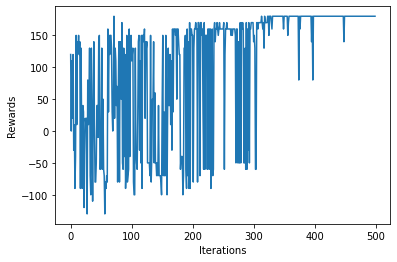

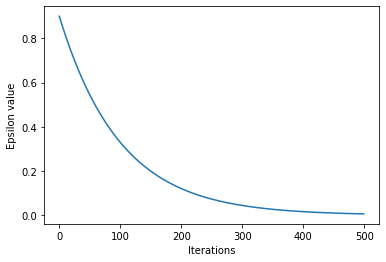

In [ ]:
#initial Deterministic setup 
environment = ParachuteLandingEnv()
sarsa_instance = Sarsa(environment,0.9,0.01,0.99,500,0.5,0.999)
sarsa_instance.fit()
plt.plot(sarsa_instance.rewards)
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.figure()
plt.plot(sarsa_instance.epsilon_values)
plt.ylabel('Epsilon value')
plt.xlabel('Iterations')

SARSA Evaluation graph for 10 episodes:

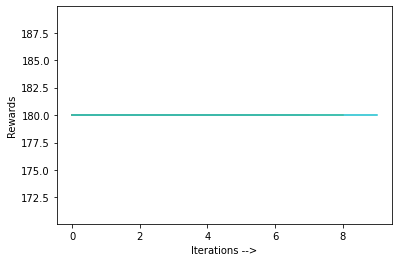

In [ ]:


cum_rewards = []
for i in range(10):
  step =0
  cum_reward = 0
  state = sarsa_instance.envs.reset()
  while(step < sarsa_instance.envs.max_timesteps):
    agent_curr = sarsa_instance.get_agent_position(state)
    next_action = np.argmax(sarsa_instance.Q[agent_curr,:])
    state2, reward1, reward2, done, info = sarsa_instance.envs.step(next_action)
    agent_next = sarsa_instance.get_agent_position(state2)
    agent_curr = agent_next
    state= state2
    cum_reward+=(reward1 + reward2)/2
    if done:
      break
  cum_rewards.append(cum_reward)
  plt.plot(cum_rewards)
  plt.xlabel('Iterations -->')
  plt.ylabel('Rewards')

DQN Implementation:

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward' , 'done'))

class ReplayMemory(object):

    def __init__(self, capacity, observation_size):
        self.capacity = capacity
        self.curr_state = [torch.zeros(capacity , observation_size), torch.zeros(capacity , observation_size)]
        self.action = torch.zeros(capacity , 1)
        self.next_state= [torch.zeros(capacity,  observation_size), torch.zeros(capacity,  observation_size)]
        self.reward = [torch.zeros(capacity, 1),torch.zeros(capacity, 1)]
        self.done = torch.zeros(capacity , 1)
        self.num_in_queue = 0
        self.ending_position = 0

    def push(self, state ,action , reward, next_state, done):
      # print('self.curr_state = ',self.curr_state)
      # print('self.self.ending_position = ',self.ending_position)
      # print('state = ',state)
      # print('state.float() = ',state.float())
      # self.curr_state[self.ending_position] = state[0].float()
      # self.next_state[self.ending_position] = next_state[0].float()
      self.done[self.ending_position] = done
      for i in range(0,2):
          self.reward[i][self.ending_position] = float(reward[i])
          self.curr_state[i][self.ending_position]  = state[i].float()
          
      if len(next_state)>1:
        for i in range(0,2):
          self.next_state[i][self.ending_position] = next_state[i].float()# (next_state.to(torch.float)).float()
      else:
        # for i in range(0,2):
        # print(" next_state error = ",next_state)
        self.next_state[0][self.ending_position] = next_state[0].float()# (next_state.to(torch.float)).float()
        self.next_state[1][self.ending_position] = next_state[0].float()# (next_state.to(torch.float)).float()
      self.action[self.ending_position] = float(action)
      self.ending_position = (self.ending_position + 1) % self.capacity
      self.num_in_queue = min(self.num_in_queue + 1 , self.capacity)
      
    def sample(self, batch_size):
        indexer = random.choices(range(self.num_in_queue) , k = batch_size)
        # print(" random indexer for sample = ",indexer)
        # print(" self.reward array = ",self.reward[0])
        # for i in range(0,2):
        state = [self.curr_state[0][indexer], self.curr_state[1][indexer]]
        next_state = [self.next_state[0][indexer], self.next_state[1][indexer]]
        # for i in range(0,2):
        reward1 = self.reward[0][indexer]
        action = self.action[indexer]
        reward2 = self.reward[1][indexer]
        reward = (reward1 + reward2)/2
        done = self.done[indexer]
        return state, reward ,action , next_state ,done

    def __len__(self):
        # print(" len of memory = ",self.num_in_queue)
        return self.num_in_queue

In [ ]:
class DQNNetwork(nn.Module):
  def __init__(self , input_size , hidden_layer, output_size) -> None:
    super(DQNNetwork , self).__init__()
    self.fc1 = nn.Linear(input_size,hidden_layer)
    self.leakyrelu = nn.LeakyReLU()
    self.relu  = nn.ReLU()
    self.fc2 = nn.Linear(hidden_layer , hidden_layer *2)
    self.fc3 = nn.Linear(hidden_layer*2 , output_size)

  def forward(self , x):
    x = self.fc1(x)
    x = self.leakyrelu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.8
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 0.999
TARGET_UPDATE =4
episodes  = 500
lr = 0.001
epsilon_values = []
environment = ParachuteLandingEnv()
n_states = environment.observation_space.n
n_actions = environment.action_space.n
train_network = DQNNetwork(n_states , 64, n_actions)
target_network = DQNNetwork(n_states , 64, n_actions)

def next_action(state,actions):
  global epsilon
  epsilon = epsilon * EPS_DECAY
  # action = []
  if epsilon < EPS_END:
    epsilon = EPS_END
  prob =np.random.rand()
  if prob > epsilon:
    # print("  state[0] = ",state[0])
    # print("train_network(state[0]) = ",train_network(state[0]))
    # print("torch.argmax(train_network(state[0]) = ",torch.argmax(train_network(state[0])))
    network1 = train_network(state[0])
    network2 = train_network(state[1])
    # print(" half 1 = ",torch.mul(network1,0.5))
    # print(" half 2 = ",torch.mul(network2,0.5))
    trainedAvgArr = torch.add(torch.mul(network1,0.5),torch.mul(network2,0.5))
    # for t in range(0, 9):
    #   trainedAvgArr.append((network1[t] + network2[t])/2)
    # print(" trainedAvgArr = ",trainedAvgArr)
    # print(" torch.argmax(trainedAvgArr) = ",torch.argmax(torch.tensor(trainedAvgArr)))
    action = torch.argmax(trainedAvgArr)
    # else:
    #   action = [torch.argmax(train_network(state[0])),torch.argmax(train_network(state[0]))]
    # action[1] = torch.argmax(train_network(state[1]))
    return np.array(action)
  else:
    action = np.random.randint(actions)
  return action


In [ ]:
memory = ReplayMemory(5000, environment.observation_space.n)

In [ ]:
def train():
  # print(" len(memory)[0] = ",len(memory))
  if len(memory) < BATCH_SIZE:
    return
  optimizer.zero_grad()
  curr_state, reward, action , next_state, done = memory.sample(BATCH_SIZE)
  # print("train_network(curr_state[0]) = ",train_network(curr_state[0]))
  # print(" torch.as_tensor(action[0].long()) ", action.long())
  # print(" not long action = ", action)
  # print(" train_network(curr_state[0]).gather(1, action.long() = ",train_network(curr_state[0]).gather(1, action.long()))
  curr_valuesArr = [train_network(curr_state[0]).gather(1, action.long()), train_network(curr_state[0]).gather(1, action.long())]
  curr_values = torch.add(torch.mul(curr_valuesArr[0],0.5),torch.mul(curr_valuesArr[1],0.5))
  # curr_values = torch.gather(train_network(curr_state), 1, torch.as_tensor(action[0].long()))
  # print("curr_values = ",curr_values)
  targetValArr = [target_network(next_state[0]).max(1).values.unsqueeze(1), target_network(next_state[1]).max(1).values.unsqueeze(1)]
  targetVals = torch.add(torch.mul(targetValArr[0],0.5),torch.mul(targetValArr[1],0.5))
  target =  reward + torch.mul((GAMMA *targetVals), 1 - done)
  loss = criterion(curr_values , target)
  loss.backward()
  optimizer.step()
  return loss


In [ ]:
def get_one_hot_encoding(state):
  # print("one hot state = ",state)
  if state is None:
    return None
  index, = np.where(np.isclose(state, 1))
  # print("index = ",index)
  # print("one hot state return = ",nn.functional.one_hot(torch.tensor(index) , len(state)).to(torch.float))
  return nn.functional.one_hot(torch.tensor(index) , len(state)).to(torch.float)

GENERATE DQN TRAINING AND EPSILON DECAY GRAPH FOR 500 EPISODES

 Running episode :  0
 Running episode :  100
 Running episode :  200
 Running episode :  300
 Running episode :  400


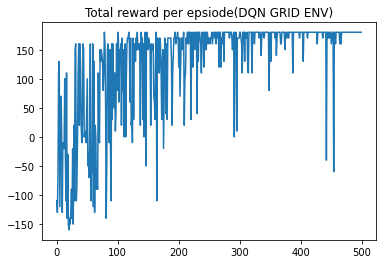

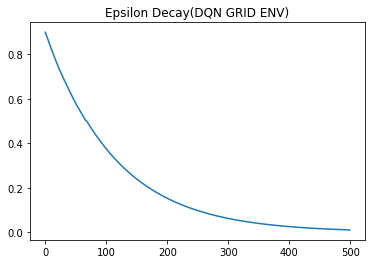

In [ ]:
cum_rewards = []
epsilon = EPS_START
BATCH_SIZE = 256
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()

for i in range(episodes):
  epsilon_values.append(epsilon)
  if i%100 == 0:
    print(" Running episode : ",i)
  resetRet = environment.reset()
  # print("resetRet = ",resetRet)
  state = get_one_hot_encoding(resetRet)
  # print ("first one hot = ",state)
  rewards = 0
  for j in count():
    action= next_action(state, environment.action_space.n)
    # print("action = ",action)
    observation , reward0, reward1 , done , info = environment.step(action)
    # print(" reward0 from step = ",reward0)
    # print("observation = ",observation)
    # if done:
    #   cum_rewards.append(rewards)
    #   break
    # print(" observation before next_state = ",observation)
    next_state = get_one_hot_encoding(observation)
    # print ("next one hot = ",next_state)
    # print("observation = ",observation)
    # print(" state = ",state)
    # print(" next_state = ",next_state[0])
    # print(" reward = ",reward)
    rewards = rewards + (reward0 + reward1)/2
    rewardArr = [reward0, reward1]
    # print(" state = ", state)
    # print(" next_state = ", next_state)
    memory.push(state, action , rewardArr,next_state, float(done)),
    state = next_state
    loss = train() 
    if done:
      cum_rewards.append(rewards)
      break
    # print(" loss = ",loss)
    
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DQN GRID ENV)")
plt.plot(cum_rewards)
plt.show()
plt.title("Epsilon Decay(DQN GRID ENV)")
plt.plot(epsilon_values)

DOUBLE DQN Implementation:

In [ ]:
def ddqn_train():
  if  len(memory) < BATCH_SIZE:
    return
  optimizer.zero_grad()
  curr_state, reward, action , next_state, done = memory.sample(BATCH_SIZE)

  curr_valuesArr = [train_network(curr_state[0]).gather(1, action.long()), train_network(curr_state[0]).gather(1, action.long())]
  curr_values = torch.add(torch.mul(curr_valuesArr[0],0.5),torch.mul(curr_valuesArr[1],0.5))
  # curr_values = torch.gather(train_network(curr_state), 1, torch.as_tensor(action[0].long()))
  # print("curr_values = ",curr_values)
  next_valArr = [target_network(next_state[0]).max(1).values.unsqueeze(1), target_network(next_state[1]).max(1).values.unsqueeze(1)]
  next_values = torch.add(torch.mul(next_valArr[0],0.5),torch.mul(next_valArr[1],0.5))
  argmax_actions = torch.argmax(next_values,dim=1).reshape(BATCH_SIZE , 1)

  targetValArr = [target_network(next_state[0]), target_network(next_state[1])]
  targetVals = torch.add(torch.mul(targetValArr[0],0.5),torch.mul(targetValArr[1],0.5))

  target =  reward + torch.mul((GAMMA *targetVals.gather(1, argmax_actions)), 1 - done)

  loss = criterion(curr_values , target)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
n_states = environment.observation_space.n
train_network = DQNNetwork(n_states, 64 , environment.action_space.n)
target_network = DQNNetwork(n_states, 64, environment.action_space.n)
print(train_network)

DQNNetwork(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
)


In [ ]:
memory = ReplayMemory(5000 , environment.observation_space.n)

DOUBLE DQN Training and Epsilon Decay graph for 500 episodes:

Starting episode =  0
Starting episode =  100
Starting episode =  200
Starting episode =  300
Starting episode =  400


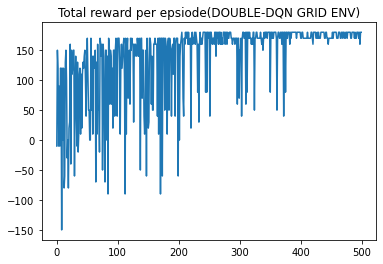

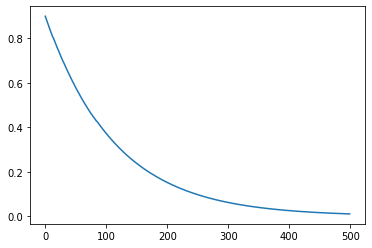

In [ ]:
cum_rewards = []
epsilon_values = []
epsilon = EPS_START
BATCH_SIZE = 256
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
episodes = 500
momentum = 0.1

for i in range(episodes):
  epsilon_values.append(epsilon)
  if i%100 == 0:
    print("Starting episode = ",i)
  state = get_one_hot_encoding(environment.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment.action_space.n)
    observation , reward0, reward1 , done , info = environment.step(action)
    rewards += (reward0 + reward1)/2
    rewardArr = [reward0, reward1]
    next_state = get_one_hot_encoding(observation)
    memory.push(state, action , rewardArr,next_state, float(done)),
    state = next_state
    loss = ddqn_train() 
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DOUBLE-DQN GRID ENV)")
plt.plot(cum_rewards)
plt.show()
plt.plot(epsilon_values)


A2C Implementation:

In [ ]:
class A2C_myenv:
    def __init__(self, env, actor, critic, seed, num_eps, box):
        self.env = env
        env.seed(seed)
        if box == False:
            self.observation_space = self.env.observation_space.n
        else:
            self.observation_space = self.env.observation_space.shape[0]
        
        self.action_space = self.env.action_space.n
        self.actor_net = actor(self.observation_space, self.action_space, seed).to(device)
        self.critic_net = critic(self.observation_space, seed).to(device)
        self.seed = random.seed(seed)
        self.actor_optim = optim.Adam(self.actor_net.parameters(), lr = 0.08)
        self.critic_optim = optim.Adam(self.critic_net.parameters(), lr = 0.08)
        self.gamma = 0.9
        self.num_eps = num_eps
        self.eps_rew = []
        self.avg_rew = []
        
    def pick_action(self, state):
        probs = self.actor_net(state)
        dist = Categorical(probs=probs)
        action = dist.sample()
        return action, dist
        
    def train(self):
        for i in range(self.num_eps):
            if i%100 == 0:
                print(i,'training...')
            done = False
            tot_rew = 0
            state = self.env.reset()
            state = torch.tensor((state), dtype = torch.float, device = device)
            t = 0
            while not done:
                action, dist= self.pick_action(state)
                # print(" action = ",action.detach().data.cpu().numpy())
                next_state, rew1, rew2, done, info = self.env.step(action.detach().data.cpu().numpy())
                next_state = torch.tensor((next_state), dtype = torch.float, device = device)
                adv = rew1 + rew2 + (1-done)*self.gamma*self.critic_net(next_state) - self.critic_net(state)
                tot_rew += (rew1 + rew2)
                state = next_state
                
                loss_c = adv.pow(2)[0]
                self.critic_optim.zero_grad()
                loss_c.backward()
                self.critic_optim.step()
                
                loss_a = -dist.log_prob(action)*adv.detach()
                self.actor_optim.zero_grad()
                loss_a.backward()
                self.actor_optim.step()
                t += 1
            
            self.eps_rew.append(tot_rew/2)     
            self.avg_rew.append(tot_rew/t)
        print('training done')

In [ ]:
class Critic(nn.Module):
    def __init__(self, no_states, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class Actor(nn.Module):
    def __init__(self, no_states, no_actions, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 24)
        self.fc2 = nn.Linear(24, 16)
        self.fc3 = nn.Linear(16, no_actions)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc3(x),dim=-1)
        return x

In [ ]:
env = ParachuteLandingEnv()
myenv_agent = A2C_myenv(env, Actor, Critic, 35, 500, 0)

In [ ]:
myenv_agent.train()

0 training...
100 training...
200 training...
300 training...
400 training...
training done


A2C TRAINING GRAPH for 500 episodes:

average rewards per episode: 89.1


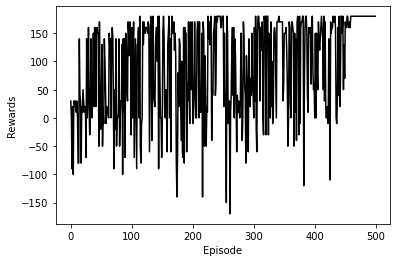

In [ ]:
plt.figure()
plt.plot(myenv_agent.eps_rew,'k')
plt.ylabel('Rewards')
plt.xlabel('Episode')
print('average rewards per episode:', sum(myenv_agent.eps_rew)/500)

A2C EVALUATION GRAPH FOR 10 EPISODES:

average rewards per episode using greedy action: 180.0


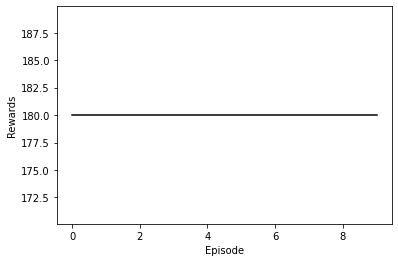

In [ ]:
plt.figure()
totalRewards = 0
TestEpisodesAfterTraining = []
for i in range(490, 500):
  totalRewards += myenv_agent.eps_rew[i]
  TestEpisodesAfterTraining.append(myenv_agent.eps_rew[i])
plt.plot(TestEpisodesAfterTraining,'k')
plt.ylabel('Rewards')
plt.xlabel('Episode')
print('average rewards per episode using greedy action:', totalRewards/10)